In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from astropy.constants import c
from scipy.fftpack import fft, fftfreq
c = c.value*1e-6 #Speed of light in mm/ns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import scipy.optimize as op
import emcee
import corner

In [2]:
T = 0.9763
R = 0.0234
A = 0.0003
L = 2.25*25.4
nu_fsr = c/(2*L)
print nu_fsr

2.62285615048


In [31]:
min_x =  int(140/nu_fsr) + 1
max_x = min_x + 10
n = 2**15
x = np.linspace(min_x, max_x, n)
nu = x*nu_fsr
F = 4*R/(1-R)**2
x = nu/nu_fsr
delta = 2*np.pi*x
P = (T/(1-R))**2*1./(1 + F*np.sin(delta/2)**2)
P_err = np.ones_like(P)

I will use the MLE models to fit an n-term fourier series to the FP fringes. 

The model in hand is described by:
$P(x) = a_0 + \sum\limits_{k=1}^n c_k \cos\left(2 \pi k x \right) + s_k \sin\left(2 \pi k x \right) $. Here $ x = \nu/\Delta \nu $ with $ \Delta \nu $ being the free spectral range is my independent variable. P(x) has a period of 1 in x. 

In [22]:
def fourierseries(x, theta):
    # Fits for the first n terms of a fourier series for a period equal to 1.
    """
    Returns the n term fourier series expansion of a function which has a period of 1 in x and has the fourier
    coefficients theta. n is given by (len(theta)-1)/2. Therefore len(theta) must be odd.
    """
    assert (len(theta)%2)==1, "The length of theta must be odd"
    n = (len(theta)-1)/2 # Remember n isn't the length of the array.It is the number of terms in the fourier expansion.
#     b0 = theta[0]
#     c_k = theta[1:n+1] - to get n terms!!!!
#     s_k = theta[n+1:] - to get n terms!!!!
    # Lambda functions for each term in the fourier series
    index = np.arange(1,n+1)
    fourier_cterm = lambda ck, k: ck*np.cos(2*np.pi*x*k)
    fourier_sterm = lambda sk, k: sk*np.sin(2*np.pi*x*k)
    
    return theta[0] + np.sum(map(fourier_cterm, theta[1:n+1], index),axis=0)+\
    np.sum(map(fourier_sterm, theta[n+1:], index),axis=0)

In [37]:
# Let's first try and do a 2 term fit to the data above.
n = 3
k = np.arange(1,n+1)
phi_k = 2*np.pi*k*x[0]
b0 = np.average(P)
b_k = 2*R**k*b0
c_k = b_k*np.cos(2*np.pi*k*x[0])
s_k = b_k*np.sin(2*np.pi*k*x[0])
guesses = [b0] +list(c_k) + list(s_k)

0.999386593928
0.999385717957


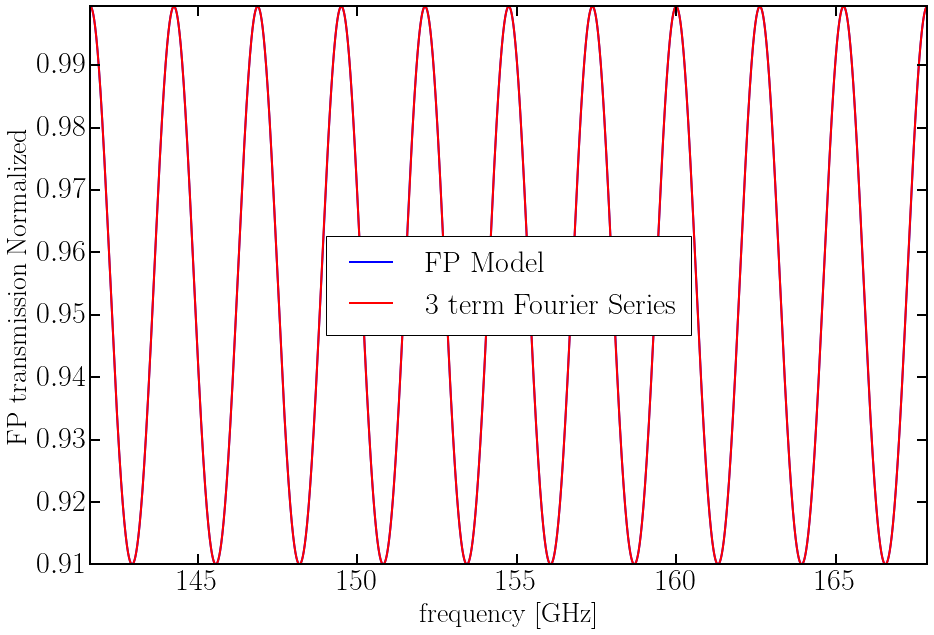

In [38]:
P_2 = fourierseries(x, guesses)
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b', label='FP Model')
ax.plot(nu, P_2, 'r', label=r'%d term  Fourier Series'%n)
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');
ax.legend(loc='best')

# fig, ax = plt.subplots(figsize=(15,10))
# ax.plot(nu, error)  # Fourier Coefficients 
# ax.plot(max_nu, error[max_indices], 'rd', markersize=20, label='Maxima of FP')
# ax.plot(min_nu, error[min_indices], 'kd', markersize=20, label='Minima of FP')
# # ax.axis('tight')
# ax.set_xlabel('k')
# ax.set_yticklabels(['%1.2g' %t for t in ax.get_yticks()]);
# ax.set_ylabel('Error')
# ax.legend(loc='best')
# print np.average(error**2)**0.5
print P_2[0]
print P[0]

In [34]:
#Let's see if using the likelihood function will be more useful
def lnlike(theta, x, y, yerr):
    model = fourierseries(x, theta)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guesses, args=(x, P,P_err))
print result['x']
print result['message']
chisq =  lnlike(result['x'],x,\
             P,P_err)
print chisq
b0 = result['x'][0]
b_k = (result['x'][1:n+1]**2 + result['x'][n+1:]**2)**0.5

[  9.53683882e-01   4.46323986e-02   1.04439089e-03   2.44315066e-05
  -7.44794736e-09  -7.44794736e-09  -7.44794736e-09]
Optimization terminated successfully.
-2.6842709753e-09


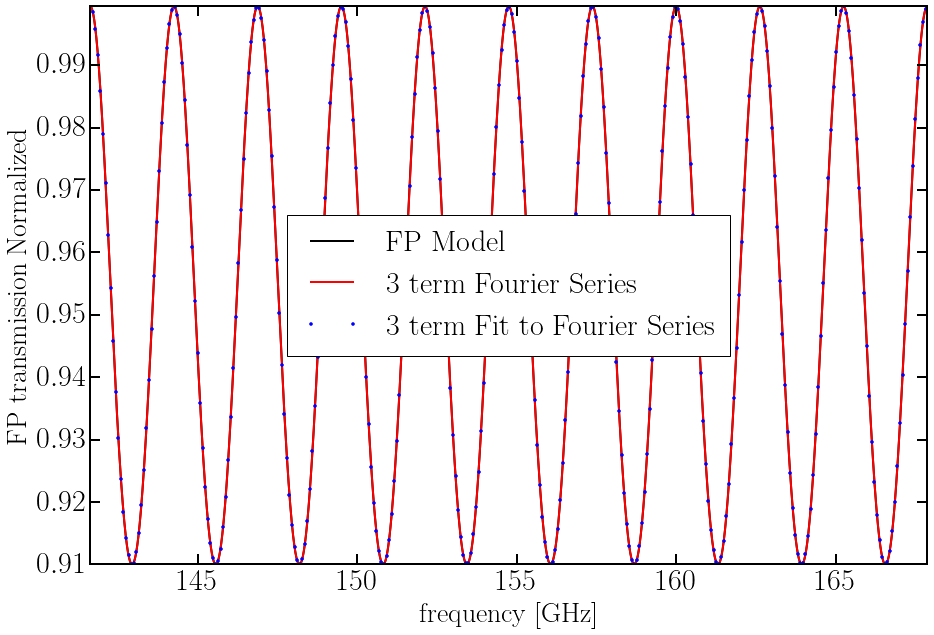

In [46]:
P_fit = fourierseries(x, result['x'])
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'k', label='FP Model')
ax.plot(nu, P_2, 'r', label=r'%d term  Fourier Series'%n)
ax.plot(nu[::100], P_fit[::100], 'b.', label=r'%d term Fit to Fourier Series'%n)
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');
ax.legend(loc='best');

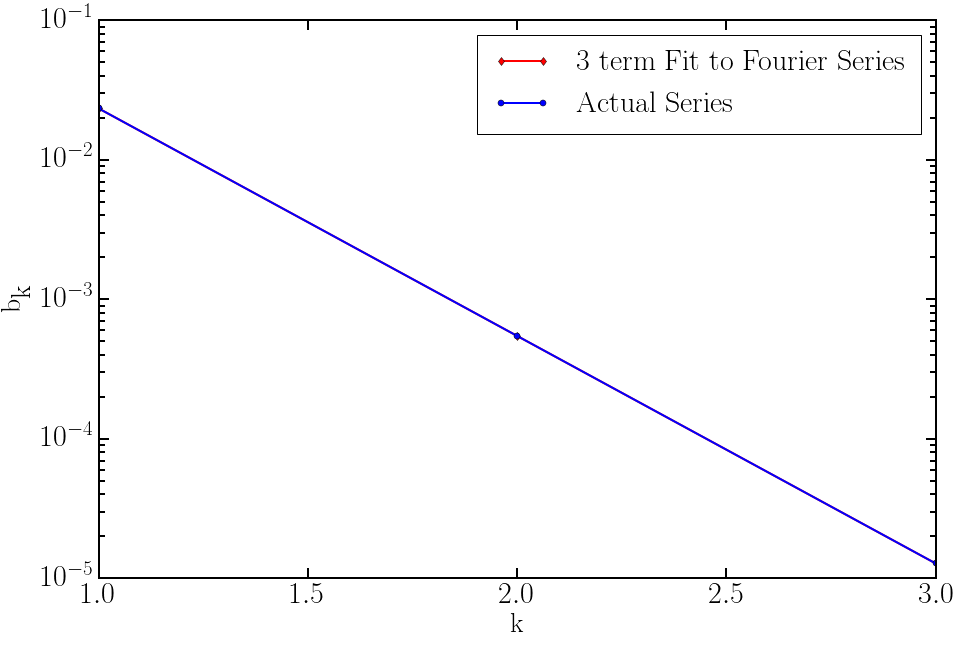

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
ax.semilogy(k, b_k/(2*b0),'rd-', label='%d term Fit to Fourier Series'%n)
ax.semilogy(k, R**k,'bo-', label = 'Actual Series')
ax.set_xlabel('k')
ax.legend(loc='best')
ax.set_ylabel(r'$\textrm{b}_{\textrm{k}}$');

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b')
ax.plot(nu, P_series, 'r')
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');

In [ ]:
# Let's see if the fourier coefficients reproduce R
R_try = (b_k/(2*b0))**(1./index)
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index[:10], R_try[:10])
ax.hlines(R, 0, 10.0, colors=u'k')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'Estimates of R');

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index, c_k/(2*b0), 'r')  # Fourier Coefficients 
ax.stem(index, R_k, 'b')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'$\textrm{c}_{\textrm{k}}$');

In [ ]:
ratio = R_k/(c_k/(2*b0))
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(index, ratio, 'r')  
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'Ratio');

In [ ]:
index2 = np.arange(len(P[mask]))
y = rfft(error[mask])/N
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index2, y.real, 'b')  # Fourier Coefficients 
# ax.stem(index2, y.imag, 'b')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k');

In [ ]:
len(index)

In [ ]:
ax.stem?

In [ ]:
c_k[10]

In [ ]:
y = np.array([0,1,2,3,4,5,6,7,8,9,10])
y[1:-1:2]

In [ ]:
print y[1:11:2]
print y[2:11:2]
len(index)

In [ ]:
y[1:11:2]

In [ ]:
np.linspace?

In [17]:
y = range(11)

In [19]:
y[1:6]

[1, 2, 3, 4, 5]

In [20]:
[1] + [2]

[1, 2]

In [ ]:
list